iter=1: norm=0.0893433
Object cannot be plotted directly, projecting to piecewise linears.
iter=2: norm=0.0266297
Object cannot be plotted directly, projecting to piecewise linears.
iter=3: norm=0.0163815
Object cannot be plotted directly, projecting to piecewise linears.
iter=4: norm=0.0103614
Object cannot be plotted directly, projecting to piecewise linears.
iter=5: norm=0.00734338
Object cannot be plotted directly, projecting to piecewise linears.
iter=6: norm=0.00570602
Object cannot be plotted directly, projecting to piecewise linears.
iter=7: norm=0.00486293
Object cannot be plotted directly, projecting to piecewise linears.
iter=8: norm=0.00421948
Object cannot be plotted directly, projecting to piecewise linears.
iter=9: norm=0.00364896
Object cannot be plotted directly, projecting to piecewise linears.
iter=10: norm=0.00315648
Object cannot be plotted directly, projecting to piecewise linears.
iter=11: norm=0.00273718
Object cannot be plotted directly, projecting to piecewise

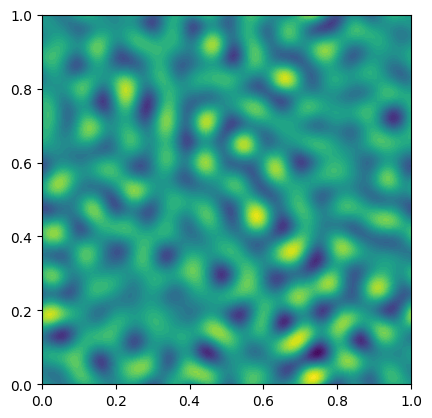

In [2]:
from dolfin import *
import numpy as np
from numpy.random import random


# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0)
        return bool((near(x[0], 0) or near(x[1], 0)) and \
                (not ((near(x[0], 0) and near(x[1], 1)) or \
                        (near(x[0], 1) and near(x[1], 0)))) and on_boundary)





    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        if near(x[0], 1) and near(x[1], 1):
            y[0] = x[0] - 1.
            y[1] = x[1] - 1.
        elif near(x[0], 1):
            y[0] = x[0] - 1.
            y[1] = x[1]
        else:   # near(x[1], 1)
            y[0] = x[0]
            y[1] = x[1] - 1.

#Initial condtions (Random)
class IC(UserExpression):
    def eval(self,values,x):
        values[0] = 0.1*random() -0.1*random()
        values[1] = 0.1*random() -0.1*random()
    def value_shape(self):
        return(2,)


#Parameters
dt = 2.0e-02

Al=Constant(1.0)
b=Constant(-1.0)
c=Constant(2)
d=Constant(-1.5)
mu=Constant(0.0001)
nu=Constant(0.0006)

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True
#parameters["form_compiler"]["representation"] = "quadrature"

# Create mesh and finite element
mesh = UnitSquareMesh(180, 180)
P1 = FiniteElement("P", triangle, 1)
element = MixedElement([P1, P1])
V = FunctionSpace(mesh, element, constrained_domain=PeriodicBoundary())
plot(mesh)



# Define variational problem
(u_1, u_2) = TrialFunctions(V)
(v_1, v_2) = TestFunctions(V)

u_=Function(V) #new solution, time: n
u_1_,u_2_=split(u_)
u_n =Function(V) #old solution, time: n-1
u_n1, u_n2 =split(u_n)

u1init = IC(element = u_n.ufl_element())
u_n.interpolate(u1init)

F  = (u_1-u_n1)*v_1*dx \
     +mu*dt*inner(grad(u_1),grad(v_1))*dx\
     -dt*(Al*u_1+b*u_2)*v_1*dx\
     +(u_2-u_n2)*v_2*dx\
     +nu*dt*inner(grad(u_2),grad(v_2))*dx\
     -dt*(c*u_1+d*u_2)*v_2*dx
      
a1=lhs(F)
L1=rhs(F)
A1=assemble(a1)

t = 0.0
T=900*dt
vtkfile_u_1 = File("Turing_new/u_1.pvd","compressed")
vtkfile_u_2 = File("Turing_new/u_2.pvd","compressed")
i=0
while (t<T):
# Update current time
    i +=1
    t += dt
    b1=assemble(L1)
    solve(A1,u_.vector(),b1,"gmres","ilu")
# Save solution to file (VTK)
    
    diff = u_.vector() - u_n.vector() 
    eps = np.linalg.norm(diff, ord=np.Inf) #infinity norm
    print ("iter=%d: norm=%g" % (i, eps))
    u_n.assign(u_) # update for next iteration
    _u_1, _u_2 = u_n.split()
    vtkfile_u_1 << (_u_1, t)
    vtkfile_u_2 << (_u_2, t)
#plot the solution
    plot(u_n1)
